In [1520]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor

In [1521]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [1522]:
train = train.drop(train.loc[train["full_sq"] == 0].index)
train = train.drop(train.loc[train["full_sq"] == train["full_sq"].max()].index)
train["price_m2"] = train["price_doc"] / train["full_sq"]
train[["full_sq", "price_doc", "price_m2"]]

,full_sq,price_doc,price_m2
0,43,5850000,136046.511628
1,34,6000000,176470.588235
2,43,5700000,132558.139535
3,89,13100000,147191.011236
4,77,16331452,212096.779221
...,...,...,...
30466,44,7400000,168181.818182
30467,86,25000000,290697.674419
30468,45,6970959,154910.200000
30469,64,13500000,210937.500000


In [1523]:
def my_cross_validation(estimator, X, y, k):
    kf = KFold(n_splits=k, shuffle = True, random_state=0)
    msles = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        y_pred = y_pred.clip(0, 10_000_000)
        msle = mean_squared_log_error(y_test, y_pred)
        msles.append(msle)
        print(msle)
    return np.mean(msles), np.std(msles)


def normalize(features):
    for f in features:
        train[f] = (train[f] - train[f].mean()) / train[f].max()
        test[f] = (test[f] - test[f].mean()) / test[f].max()

# Model 1

In [1524]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq']
for f in features:
    train[f] = train[f].fillna(train[f].median())
    test[f] = test[f].fillna(test[f].median())

In [1525]:
model1 = SGDRegressor(random_state=0)
res = my_cross_validation(model1, train[features], train["price_m2"], 10)
res

0.7211929190037075
5.031910767346402
0.5100759445765699
0.2930918377990794
10.981923155948333
99.3688982001877
2.706962227393917
0.875227160926547
0.3941092731426092
0.5692532834157477


(12.14526447697406, 29.24801777481875)

In [1526]:
model1.fit(train[features], train["price_m2"])
y_pred = model1.predict(test[features])
y_pred

array([291665.72258228,  -8203.97579494, 122876.8694315 , ...,
         9436.90707557, 231595.48036643,  20689.39490155])

In [1527]:
submission = pd.read_csv('sample_submission.csv')
submission['price_doc'] = (test['full_sq'] * y_pred).clip(0, 1000_000_000)
submission.to_csv('predict1.csv', index = False)

cv msle mean/std 12.14526447697406, 29.24801777481875

lb private/public 8.00372 7.90821

# Model 2

In [1528]:
test["full_sq_m2"] = test.loc[:, "full_sq"]
normalize(features)
test

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,full_sq_m2
0,30474,2015-07-01,-0.036479,20.7,2,9,1,1998.0,1,8.9,...,0,0,0,1,10,1,0,14,1,39.00
1,30475,2015-07-01,0.063273,NaN,8,17,1,0.0,3,1.0,...,1,1,0,2,11,0,1,12,1,79.20
2,30476,2015-07-01,-0.032757,25.1,3,5,2,1960.0,2,4.8,...,11,4,0,10,21,0,10,71,11,40.50
3,30477,2015-07-01,0.022578,36.0,17,17,1,2016.0,2,62.8,...,1,2,0,0,10,0,0,2,0,62.80
4,30478,2015-07-01,-0.033998,40.0,17,17,1,0.0,1,1.0,...,1,1,0,2,12,0,1,11,1,40.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,38131,2016-05-26,-0.003725,31.8,10,12,5,1973.0,2,9.1,...,28,1,1,8,39,2,3,75,12,52.20
7658,38132,2016-05-28,0.000965,NaN,14,0,1,NaN,2,0.0,...,2,1,0,0,10,0,0,0,0,54.09
7659,38133,2016-05-30,-0.031318,1.0,12,1,1,1.0,1,1.0,...,371,141,26,150,249,2,105,203,13,41.08
7660,38134,2016-05-30,-0.046901,19.8,8,9,5,1977.0,1,6.4,...,7,2,0,5,11,0,2,43,10,34.80


(-2.0, 2.0)

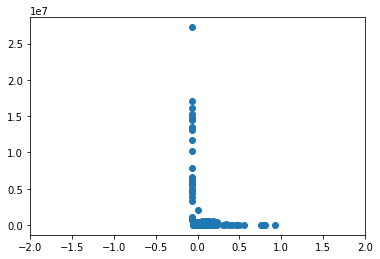

In [1529]:
plt.scatter(x=train["full_sq"], y=train["price_m2"])
plt.xlim(-2, 2)

In [1530]:
model2 = SGDRegressor(random_state=0)
res = my_cross_validation(model2, train[features], train["price_m2"], 10)
res

0.5423645921763799
0.34647435282626005
0.3848080726132822
0.3178839374328493
0.3892964523207615
0.4582100328558902
0.48746883778855465
0.5471743166347882
0.3886990407077922
0.42770826312629895


(0.4290087898482858, 0.0744317982860507)

In [1531]:
model2.fit(train[features], train["price_m2"])
y_pred = model2.predict(test[features])
y_pred

array([121075.98109503, 100345.29485936, 162159.30107795, ...,
       191636.90695032, 146468.41869718, 137648.83907707])

In [1532]:
submission = pd.read_csv('sample_submission.csv')
submission['price_doc'] = (test["full_sq_m2"] * y_pred).clip(0, 1000_000_000)
submission.to_csv('predict2.csv', index = False)

cv msle mean/std 0.4290087898482858, 0.0744317982860507

lb private/public 0.84866 0.49540

# Model 3

In [1533]:
train['product_type'] = train['product_type'].replace( { 'Investment':1,'OwnerOccupier':0, np.nan:0  })
test['product_type'] = test['product_type'].replace( { 'Investment':1,'OwnerOccupier':0, np.nan:0  })

sub_area_target_encoding =  train.groupby(['sub_area'])['price_m2'].mean()
train['sub_area'] = train['sub_area'].replace( sub_area_target_encoding)
test['sub_area'] = test['sub_area'].replace( sub_area_target_encoding)
normalize(["sub_area"])

features += ['product_type', 'sub_area']


In [1534]:
train[features]

,metro_km_walk,kremlin_km,full_sq,product_type,sub_area
0,-0.040980,-0.012554,-0.015151,1,-0.010564
1,-0.049352,-0.103850,-0.027496,1,0.228813
2,-0.035670,-0.098622,-0.015151,1,-0.012333
3,-0.043806,0.048668,0.047950,1,0.105811
4,-0.048445,-0.190357,0.031489,1,0.184014
...,...,...,...,...,...
30466,-0.048597,-0.048700,-0.013779,1,0.011678
30467,-0.046886,-0.180594,0.043834,1,-0.045641
30468,-0.031009,0.082861,-0.012407,0,-0.083107
30469,-0.025524,-0.034235,0.013656,1,0.075142


In [1535]:
model3 = SGDRegressor(random_state=0)
res = my_cross_validation(model3, train[features], train["price_m2"], 10)
res

0.3323290535149364
0.27284314932114423
0.33135502993001426
0.3655899240996712
0.35612654946032507
0.35534978501726955
0.2889864442233232
0.3973863752373064
0.36252786957258865
0.40905954807964456


(0.34715537284562237, 0.04056409576496447)

In [1536]:
model3.fit(train[features], train["price_m2"])
y_pred = model3.predict(test[features])
y_pred

array([119504.57368738,  97721.39051888, 135286.425353  , ...,
       151953.82374594, 141565.31437467, 132730.39036241])

In [1537]:
submission = pd.read_csv('sample_submission.csv')
submission['price_doc'] = (test["full_sq_m2"] * y_pred).clip(0, 1000_000_000)
submission.to_csv('predict3.csv', index = False)

cv msle mean/std 0.34715537284562237, 0.04056409576496447

lb private/public 0.91851 0.50213

# Model 4

In [1538]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [1539]:
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:

    output= pd.DataFrame()
    output['timestamp']= timestamp_series
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['hour_datetime'] = timestamp_series.dt.hour.astype(np.int64)
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] = timestamp_series.dt.day.astype(np.int8)
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['seconds'] = timestamp_series.astype(np.int64) / 1_000_000_000
    output['mins'] = output['seconds'] / 60
    output['hours'] = output['mins'] / 60
    output['days'] = output['hours'] / 24
    output['months'] = output['days'] / 30
    return output

In [1540]:
train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

In [1541]:
new_features = ["hours", "month", "day_week", "year"]
normalize(new_features)
features += new_features

In [1542]:
model4 = SGDRegressor(random_state=0)
res = my_cross_validation(model4, train[features], train["price_m2"], 10)
res

0.5498803562342153
0.32878168449943923
0.3294914445705847
0.3318926230453899
0.40271457492407
0.3571477671316625
0.2967444893283009
0.41662813844047747
0.4625067355271364
0.4599809450084666


(0.3935768758709743, 0.07551182662172991)

In [1543]:
model4.fit(train[features], train["price_m2"])
y_pred = model4.predict(test[features])
y_pred

array([118135.1947263 ,  91447.06627973, 133684.50416082, ...,
       151301.09885294, 141659.4905722 , 129349.34257035])

In [1544]:
submission = pd.read_csv('sample_submission.csv')
submission['price_doc'] = (test["full_sq_m2"] * y_pred).clip(0, 1000_000_000)
submission.to_csv('predict4.csv', index = False)

cv msle mean/std 0.3935768758709743, 0.07551182662172991

lb private/public 1.00819 0.74432

# Model 5

In [1545]:
features = ['metro_km_walk', 'kremlin_km', 'full_sq', 'product_type', 'sub_area', "year"]
new_features = ["build_year", "state"]
for f in new_features:
    train[f] = train[f].fillna(train[f].median())
    test[f] = test[f].fillna(test[f].median())
train["build_year"] = train["build_year"].clip(1900, 2021)
train["state"] = train["state"].clip(train["state"].quantile(0.01), train["state"].quantile(0.99))
normalize(new_features)
features += new_features

In [1546]:
model5 = SGDRegressor(random_state=0)
res = my_cross_validation(model5, train[features], train["price_m2"], 10)
res

0.33284605580934334
0.32792295749748296
0.33362145916933234
0.3661236467988514
0.3679141427471835
0.35566742310804933
0.32976703234923643
0.38971723016952464
0.33338623444371107
0.410196262157705


(0.35471624442504196, 0.027068297525129115)

In [1547]:
model5.fit(train[features], train["price_m2"])
y_pred = model5.predict(test[features])
y_pred

array([106871.6089985 , 211980.79748927, 127476.6151304 , ...,
       269867.27860682, 133685.1562923 , 118387.03821134])

In [1548]:
submission = pd.read_csv('sample_submission.csv')
submission['price_doc'] = (test["full_sq_m2"] * y_pred).clip(0, 1000_000_000)
submission.to_csv('predict5.csv', index = False)

cv msle mean/std 0.35471624442504196, 0.027068297525129115

lb private/public 1.11078 0.84864

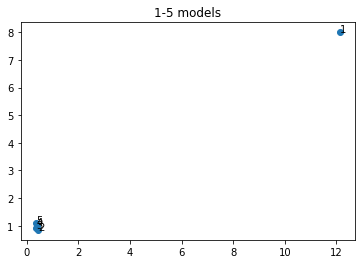

In [1549]:
lbs = [8.00372, 0.84866, 0.91851, 1.00819, 1.11078]
cvs = [12.14526447697406, 0.4290087898482858, 0.34715537284562237, 0.3935768758709743, 0.35471624442504196]
names = [1, 2, 3, 4, 5]

fig, ax = plt.subplots()
ax.scatter(cvs, lbs)
plt.title("1-5 models")
for i, txt in enumerate(names):
    ax.annotate(txt, (cvs[i], lbs[i]))

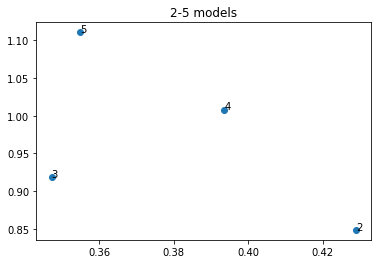

In [1550]:
fig, ax = plt.subplots()
ax.scatter(cvs[1:], lbs[1:])
plt.title("2-5 models")
for i, txt in enumerate(names[1:]):
    ax.annotate(txt, (cvs[1:][i], lbs[1:][i]))

# Вывод

Лучшей оказалась модель 2, несмотря на то,
что в последующих моделях score кросс валидации уменьшается.
Нормализация данных значительно улучшила результат.

Добавление новых фичей в модель приводила к уменьшению показателя кросс-валидации,
но итоговый результат ухудшался - модель переобучалась.
Вероятно из-за того, что добавленные фичи кореллируют между собой.